# IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.inspection import DecisionBoundaryDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool
from torch.utils.data import Subset
from scipy.stats import binom_test # library for p-value


# LOAD THE DATA 

In [2]:
# https://www.edureka.co/community/72971/how-to-load-numpy-array-in-jupyter-notebook

features = np.load("data/data/features.npy")
labels = np.load("data/data/labels.npy")

print(features.shape)
print(labels.shape)

print(set(labels))

(900, 2)
(900,)
{0.0, 1.0}


# PART 1

(array([500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

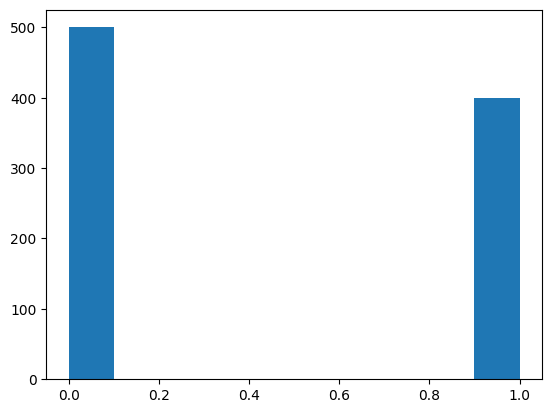

In [3]:
"""
1.
a) 2 features, 900 samples
b) binary classification since we only have 2 label values, 0 and 1
c) we can infer that we have 500 0 samples and 400 1 samples
"""

# c:
plt.hist(labels)

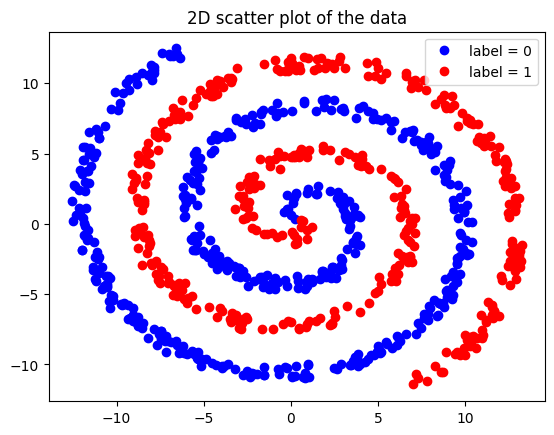

In [4]:
# Go through all the points, check ther label and plot them with the appropriate colour
label_1 = "label = 1"
label_0 = "label = 0"
for i in range(features.shape[0]):

    if labels[i] == 0:
        if label_0:
            plt.plot(features[i][0], features[i][1], "bo", label=f"{label_0}")
            label_0 = None
        else:
            plt.plot(features[i][0], features[i][1], "bo")
    else:
        if label_1:
            plt.plot(features[i][0], features[i][1], "ro", label=f"{label_1}")
            label_1 = None
        else:
            plt.plot(features[i][0], features[i][1], "ro")

plt.title("2D scatter plot of the data")
plt.legend()
plt.show()


In [5]:
"""
2.
a)...
b) the data does not look linearly speperable at first glance, since it has a spiral-like shape
c) no since the data is not linearly seperable
d) the bayes optimal lassifier would follow the spiral pattern that we can observe in the image.
   It would be able to achieve an empirical risk of 0, since the data can
   be perfectly seperated due to the lack of noise (the only somewhat problematic part might be at the very middle
   but since I am not completely sure I am making a bit of an assumption that we have 0 noise overall)
"""


'\n2.\na)...\nb) the data does not look linearly speperable at first glance, since it has a spiral-like shape\nc) no since the data is not linearly seperable\nd) the bayes optimal lassifier would follow the spiral pattern that we can observe in the image.\n   It would be able to achieve an empirical risk of 0, since the data can\n   be perfectly seperated due to the lack of noise (the only somewhat problematic part might be at the very middle\n   but since I am not completely sure I am making a bit of an assumption that we have 0 noise overall)\n'

In [6]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(720, 2)
(180, 2)


In [ ]:
"""
3.
a) The split is neccesary, because you want to be abel to train on a part of the data and then when you think you have a
   a good model, you can verify it by using your test data, since if the model is robust it will be able to work on them just fine,
   otherwise it might have overfitted.
b) TODO Well LDA is out of the question since it makes the assumption that we have Gaussian distributions
   as for the other 2, I would choose Logistic Regression, mainly because it is simplier and because
   it works with probabilities, which might be usefull in this case since a poor result is a given, considering all
   3 classifiers are linear classifiers. But I can't find any other reason to not use SVM
c) 0.6055555555555555, well the classifier is learning but still isn't performing well (to be expected) since an accuracy of 0.5 would be purely guessing.
d) ...
"""

'\n3.\na)...\nb) Well LDA is out of the question since it makes the assumption that we have Gaussian distributions\n   as for the other 2, I would choose Logistic Regression, mainly because it is simplier and because\n   it works with probabilities, which might be usefull in this case since a poor result is a given, considering all\n   3 classifiers are linear classifiers.\n'

In [6]:
def calculate_accuracy(predictions, y_test):
    correct = 0
    for i in range(len(predictions)):
        if predictions[i] == y_test[i]:
            correct += 1
    return correct/len(predictions)

In [36]:
# Create a logistic classifier, train it and check the accuracy
#log_reg_classifier = LinearDiscriminantAnalysis()
#log_reg_classifier = SVC(kernel='linear', C=1.0)
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train, y_train)
predictions = log_reg_classifier.predict(X_test)
print(calculate_accuracy(predictions, y_test))


0.6055555555555555


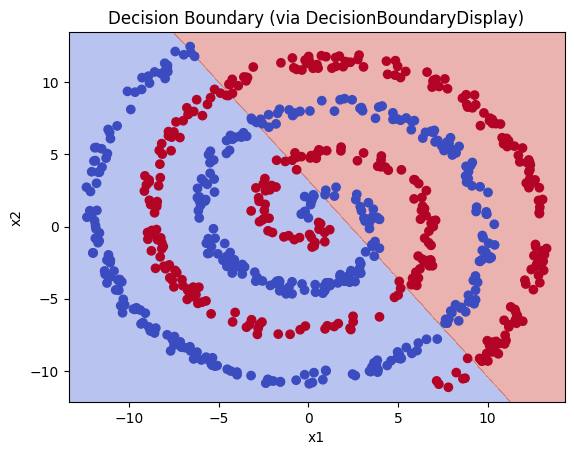

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html
# Decision boundary display
decision_boundary = DecisionBoundaryDisplay.from_estimator(
    log_reg_classifier, 
    X_train, 
    response_method="predict",
    grid_resolution=1000,
    alpha=0.4,
    cmap="coolwarm",
    xlabel="x1", 
    ylabel="x2",
)

decision_boundary.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm")
plt.title("Decision Boundary (via DecisionBoundaryDisplay)")
plt.show()

In [ ]:
"""
4.
a) 0.6, almsost the same as the classifier
b) ...
c) the plot suggests that we are pretty much guessing. We are doing slightly better, however there is a small chance that even by just guessing, 
   this accuracy could be reached.
d) well I repeated it 1000 times (as suggested in the pdf). I believe a 1000 is enough so we can get a good idea on how the accuracies are truly
   distributed. If we used less then there exists the possibility that outlier values (such as >60%) could appear a few times and scew the distribution.
   (when I say less, I mean considerably less, like 100 or 50. Obviously 900 would be just fine)
e) 0.65, so they are not the same which is to be expected. Afterall the chance accuracy will almost certaintly be different every time I run the code
   of that cell, whereas this accuracy will always statys the same, since the number of 0's and 1's in the test set doesn't ever change. Still they are close!
f) So from what we can observe guessing, picking the label that belongs to the majority of samples and training a classifier give almost the same results. The reson for this is
   because the classifier simply cant do that good of a job, because the data is not linearly seperable. Whould it be worth it to train a classifier in this case? Well it really
   depends on the task and as I stated there is some accuracy benefit but it's minimal.
"""


In [38]:
# https://www.w3schools.com/python/numpy/numpy_random_permutation.asp
y_test_random = np.random.permutation(y_test)
print(calculate_accuracy(y_test_random, y_test))

0.6


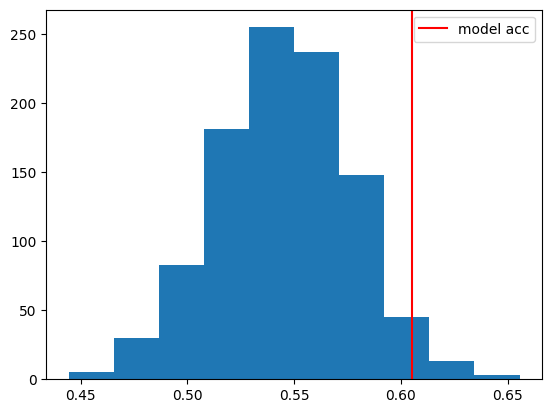

In [ ]:
# Get 1000 accuracy scores and plot them into a histogram
accuracies = []
for i in range(1000):
    y_test_random = np.random.permutation(y_test)
    accuracies.append(calculate_accuracy(y_test_random, y_test))

model_accuracy = 0.605

plt.hist(accuracies)
plt.axvline(model_accuracy, color="red", label="model acc") # https://www.geeksforgeeks.org/plot-a-vertical-line-in-matplotlib/
plt.legend()

In [41]:
# Count 0's, if it's greater than the half of the total in the test then 0, else 1
count = 0
choise = np.zeros_like(y_test)
for value in y_test:
    if value == 0:
        count += 1
if count <= len(y_test)/2:
    choise = np.ones_like(y_test)
print(calculate_accuracy(choise, y_test))

0.65


In [ ]:
"""
5.
a) ...
b) The learning curves suggest robustness and good generalization, due to both curves being fairly close to one another.
c) Well my idea was to first find a good architecture, where with enough epochs we can achieve almost perfect learning on the training data.
   I did this by adding one layer at the time, while also increasing the number of neurons (after a point, no matter how many neurons you have, 
   you won't be able to get a better accuracy without adding another layer). After doing this manually and finding a good architecture,
   I used 10Fold cross validation to fine tune the learning rate (There are countless of research papers and articles like this: https://mohitmishra786687.medium.com/the-learning-rate-a-hyperparameter-that-matters-b2f3b68324ab
   which show that just by tuning the learning rate, you should achieve the best result). Finaly I found that a learning rate of 0.01 gave me the best results.
d) ...
"""

In [ ]:
# We need to convert to pytorch tensors
X_train_nn = torch.FloatTensor(X_train)
X_test_nn = torch.FloatTensor(X_test)
y_train_nn = torch.LongTensor(y_train)
y_test_nn = torch.LongTensor(y_test)

# NN architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(2, 64)    
        self.fc2 = nn.Linear(64, 128)   
        self.fc3 = nn.Linear(128, 256)   
        self.fc4 = nn.Linear(256, 512)   
        self.fc5 = nn.Linear(512, 1024)   
        self.fc6 = nn.Linear(1024, 2)    
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize model
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
train_acc, test_acc = [], []
for epoch in range(90):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_nn)
    loss = criterion(outputs, y_train_nn)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.eval()
        # Train
        train_pred = model(X_train_nn).argmax(1)
        train_acc.append((train_pred == y_train_nn).float().mean())
        # Test
        test_pred = model(X_test_nn).argmax(1)
        test_acc.append((test_pred == y_test_nn).float().mean())

c:\Users\matsa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


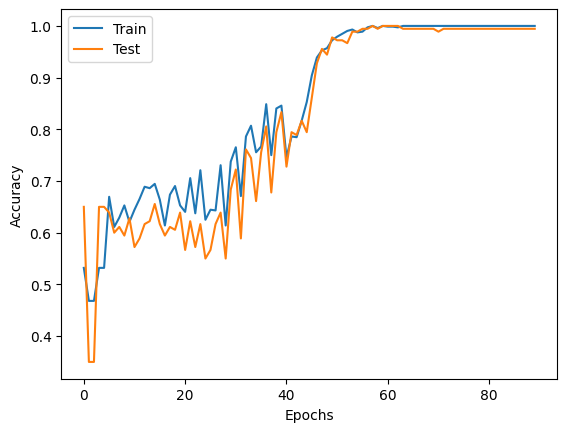

In [ ]:
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Learning rates
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05]
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

results = {}

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    fold_accuracies = []

    for train_index, val_index in kf.split(X_train_nn):
        # Split data
        X_train_cv, X_val_cv = X_train_nn[train_index], X_train_nn[val_index]
        y_train_cv, y_val_cv = y_train_nn[train_index], y_train_nn[val_index]

        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(75):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_nn)
            loss = criterion(outputs, y_train_nn)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                model.eval()
                # Validation accuracy
                val_pred = model(X_val_cv).argmax(1)
                fold_accuracies.append((val_pred == y_val_cv).float().mean())

    avg_acc = np.mean(fold_accuracies)
    results[lr] = avg_acc
    print(f"Average validation accuracy: {avg_acc}")

# Best learning rate
best_lr = max(results, key=results.get)
print("\nBest learning rate:", best_lr)

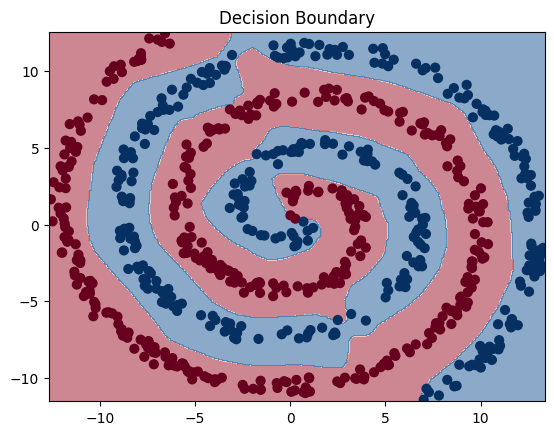

In [ ]:
# https://psrivasin.medium.com/plotting-decision-boundaries-using-numpy-and-matplotlib-f5613d8acd19

# Create mesh grid
# Range for visualization
x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1

# Create "points" (not yet points) that will use to draw the decision boundary
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))

# Create the actuall points
x_in = np.c_[xx.ravel(), yy.ravel()]
x_in_tensor = torch.FloatTensor(x_in)

# Predict
model.eval()
with torch.no_grad():
    y_pred = model(x_in_tensor).argmax(1).reshape(xx.shape)

# Plot
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.RdBu)
plt.title("Decision Boundary")
plt.show()



# PART 2

In [ ]:
"""
1.
a) 188, 7, 2 
b) Per the ai model (prompt: Can you explain what the MUTAG dataset represents? Specifically tell me what real-world object does a sample represent? What do the nodes, edges, features, and labels  correspond to.) 
   and google (https://paperswithcode.com/dataset/mutag)
   Sample: Chemical compound modeled as a graph
   Nodes: Atoms
   Edges: Bonds between the atoms
   Features: Features are one-hot encodings, so in essense the feature vector tells you what type of atom you have (Oxygen, Hydrogen, etc.) and you have 7 of those possible types
   Labels: 1 if chemical compound is mutagenic, 0 if not

c) The first sample has 17 nodes and 38 edges (prompt: how to get the nodes and edges of the first sample in the MUTAG dataset?)
d) ...

"""

In [84]:
# (https://medium.com/@james-coffey/gcn-with-neo4j-and-pytorch-using-mutag-dataset-in-ten-steps-ea3169c9c023)
dataset = TUDataset(root="data", name="MUTAG")
samples = len(dataset)
features = dataset.num_node_features
classes = dataset.num_classes
print(f"Samples: {samples}, Features: {features}, Classes: {classes}")

Samples: 188, Features: 7, Classes: 2


In [93]:
# Nodes and edges in first graph
sample = dataset[0]
nodes = sample.x
edges = sample.edge_index  
print(f"First sample has {nodes.shape[0]} nodes and {edges.shape[1]} edges")

First sample has 17 nodes and 38 edges


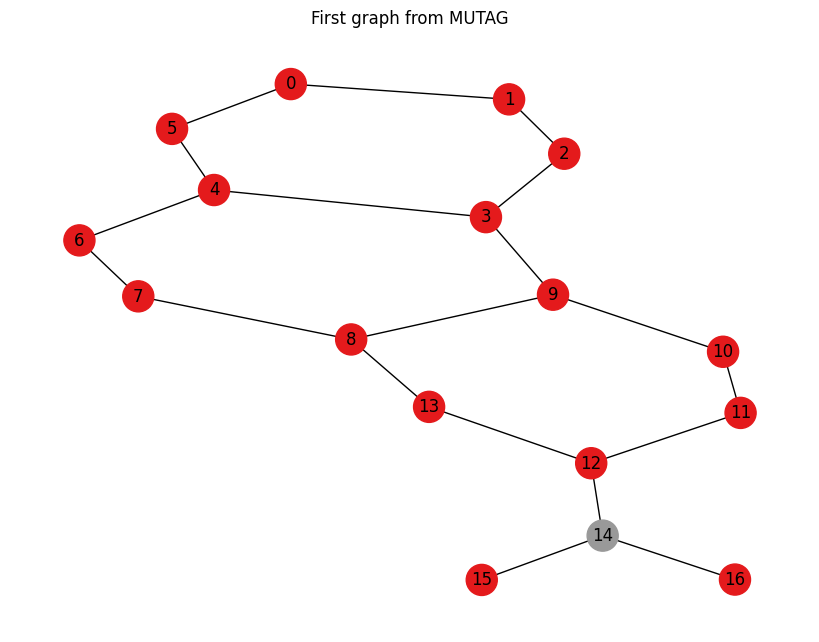

In [ ]:
# Plo graph of the first sample with nodes colored by second feature (index 1)
graph = to_networkx(sample, to_undirected=True)
node_colors = sample.x[:, 1].tolist()

plt.figure(figsize=(8, 6))
nx.draw(graph, with_labels=True, node_color=node_colors, cmap=plt.cm.Set1, node_size=500)
plt.title("First graph from MUTAG")
plt.show()

In [ ]:
"""
We shall use the same linear modle as before, so Linear Regression.
2.
a) After asking the AI "How can I prep the data so that I can train without using graph connections? I am using the mutag dataset." one of the many things it suggested was that I should get the feature vectors of all the nodes in each graph
   add them together and then devide the whole vector by the number of nodes in that set. It seemed sound to me, so I decided to follow this approach
b) ..., fairly poor results, we are learning just not all that much, peaking at arounf 70% and then consistently plateauing
c) Choosing most frequent label = 0.6648936170212766, Guessing = 0.42105263157894735, Linear = 0.5263157894736842, NN = 0.6053, overall we are doing barely better than just guessing, considering 
   that even with the NN the accuracy remains low (plateauing at around 60%)

"""

In [7]:
# Prep the data
features = []
labels = []

# Loop through each graph in the dataset
for data in dataset:
    # data.x is a tensor that for each node in the graph, will have it's feature vector
    graph_features = data.x.mean(dim=0).numpy()
    
    features.append(graph_features)

    labels.append(data.y.item())  # Convert to a single number rather than a tensor


# Split data into train and test sets (80-20 split)
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2)

# Split the training set further so that we can later use this for the validation proccess
train_idx_val, val_idx = train_test_split(range(len(train_idx)), test_size=0.2)

# Get the actual training splits
X_train = np.array([features[i] for i in train_idx])
X_test = np.array([features[i] for i in test_idx])
y_train = np.array([labels[i] for i in train_idx])
y_test = np.array([labels[i] for i in test_idx])

#X_train, X_test, y_train, y_test = 
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
#print(len(X_train))
#print(len(X_test))


In [8]:
# GREAT DATA IMBALANCE NEEDS TO BE TAKEN INTO ACCOUNT!
# What if we choose the most frequent class?
count = 0
for label in labels:
    if label == 1:
        count += 1
print(count/samples)

0.6648936170212766


In [15]:
# Guessing
y_test_shuffled = np.random.permutation(y_test)
print(calculate_accuracy(y_test_shuffled, y_test))

0.42105263157894735


In [14]:
# Linear model
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train, y_train)
predictions = log_reg_classifier.predict(X_test)
print(calculate_accuracy(predictions, y_test))

# The results are better than before. Still not great but better!

0.5263157894736842


In [32]:
# NN
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# We need to convert to pytorch tensors
X_train_nn = torch.FloatTensor(X_train)
X_test_nn = torch.FloatTensor(X_test)
y_train_nn = torch.LongTensor(y_train)
y_test_nn = torch.LongTensor(y_test)

# NN architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 64)    
        self.fc2 = nn.Linear(64, 128)   
        self.fc3 = nn.Linear(128, 256)   
        self.fc4 = nn.Linear(256, 512)   
        self.fc5 = nn.Linear(512, 512)    
        self.fc6 = nn.Linear(512, 2)    
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize model
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
train_acc, test_acc = [], []
for epoch in range(85):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_nn)
    loss = criterion(outputs, y_train_nn)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.eval()
        # Train
        train_pred = model(X_train_nn).argmax(1)
        train_acc.append((train_pred == y_train_nn).float().mean())
        # Test
        test_pred = model(X_test_nn).argmax(1)
        test_acc.append((test_pred == y_test_nn).float().mean())


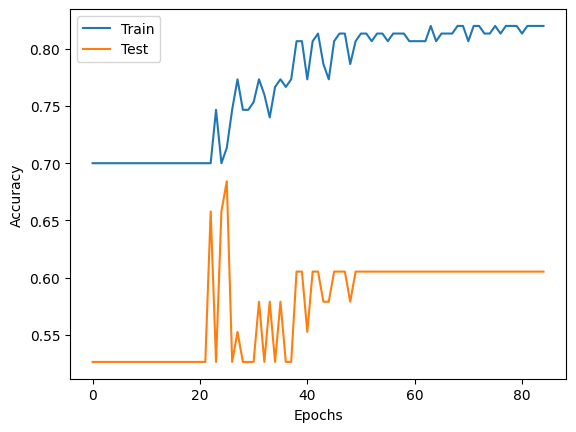

In [ ]:
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [27]:
print(test_acc[-1])

tensor(0.6053)


In [ ]:
"""
3.
a) ...
b) AI prompt : "How does a GNN take into account graph info and what does the layer number mean?"
   Per the ai and a bit of crossreferencing on google I understood that the high level idea
   is that each node doesn't just use it's own information but through message passinh it tries to take
   into account information of its surrounding/ neighboring nodes before updating it's weights. As for the layers, they tell us 
   how far the neighbor you receive onfo from can be. Layer 1 -> immediate neighbor , Layer 2 -> 
   neighbor of neighor, etc.
c) ..., in essense I just created a validation dataset from the training dataset and I manually tried out learning rates and architectures. I also
   looked a bit on batch sizes but didn't get much of a change (even though I believe this may vary a lot if you use a GPU)
d) Accuracy = 0.79, P-value = 4.051328899727381e-06 (not exactly 0 probably but pretty much 0). Looking at the accuracy, it's indeed better than before and by quite a bit. Overall on google I saw that models such
   as mine should reach around 85-90% accuracy and considering the fact that that's the range of accuracies I was able to get on previous runs, I would say the model is doing a solid job.
"""

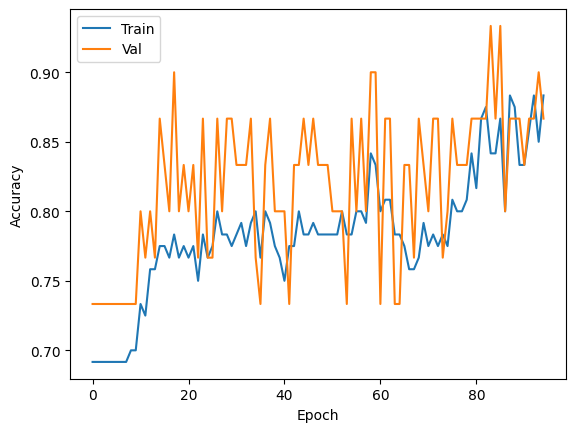

In [ ]:
# THIS PART IS USED FOR FINDING THE BEST HYPERPARAMETERS

train_dataset = Subset(dataset, train_idx)

# Create subsets for train and validation
train_subdataset = Subset(train_dataset, train_idx_val)
val_subdataset = Subset(train_dataset, val_idx)

# DataLoaders for these subsets
train_loader = DataLoader(train_subdataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subdataset, batch_size=32, shuffle=False)

# Model with GINConv layers
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        # MLP for first GINConv
        mlp1 = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc1 = GINConv(mlp1)
        
        # MLP for second GINConv
        mlp2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
        self.fc2 = GINConv(mlp2)

        # MLP for second GINConv
        mlp3 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )
        self.fc3 = GINConv(mlp3)
        
        
        self.fc6 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index, batch):
        x = self.relu(self.fc1(x, edge_index))
        x = self.relu(self.fc2(x, edge_index))
        x = self.relu(self.fc3(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling to get graph-level embedding
        x = self.fc6(x)
        return x

# rest of the code remains the same
model = Model2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_acc, val_acc = [], []
for epoch in range(95):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        # Evaluate on train_loader
        correct = 0
        total = 0
        for batch in train_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        train_acc.append(correct / total)

        # Evaluate on val_loader
        correct = 0
        total = 0
        for batch in val_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        val_acc.append(correct / total)

# Plot results
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
print(train_acc[-1])
print(val_acc[-1])

0.8833333333333333
0.8666666666666667


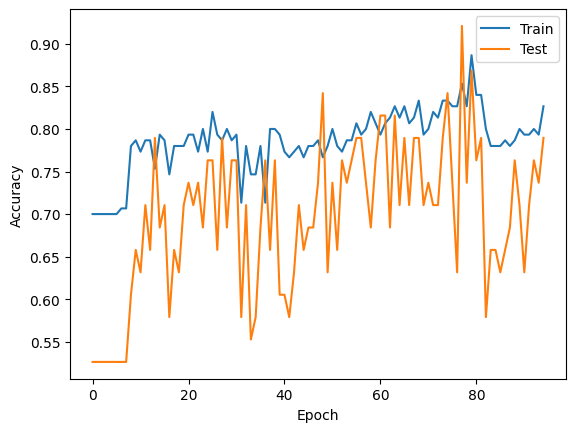

In [ ]:
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model with GINConv layers
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        mlp1 = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fc1 = GINConv(mlp1)
        
        mlp2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
        self.fc2 = GINConv(mlp2)

        mlp3 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )
        self.fc3 = GINConv(mlp3)
        
        
        self.fc6 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index, batch):
        x = self.relu(self.fc1(x, edge_index))
        x = self.relu(self.fc2(x, edge_index))
        x = self.relu(self.fc3(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling to get graph-level embedding
        x = self.fc6(x)
        return x

# rest of the code remains the same
model = Model2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_acc, test_acc = [], []
for epoch in range(95):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        # Evaluate on train_loader
        correct = 0
        total = 0
        for batch in train_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        train_acc.append(correct / total)

        # Evaluate on test_loader
        correct = 0
        total = 0
        for batch in test_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        test_acc.append(correct / total)

# Plot results
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [50]:
print(train_acc[-1])
print(test_acc[-1])

0.8266666666666667
0.7894736842105263


In [ ]:
# P-value calculation
correct = int(len(test_idx)*test_acc[-1])
total = len(test_idx)
p_value = binom_test(correct, total, p=0.42105263157894735, alternative='greater')

print(f"P-value: {p_value}")

P-value: 4.051328899727381e-06


C:\Users\matsa\AppData\Local\Temp\ipykernel_20960\1323653989.py:8: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(correct, total, p=0.42105263157894735, alternative='greater')


In [ ]:
"""
4.
a) ...
b) After some tests I found that using 2 + 14*2 (14 GIN layers with 2 linear layers each) with almost all having 6 input and 6 output layers (the input was 7in 6out and the final 2 layers where 6in 2out
   and 2in 2out respectively) gave me pretty good results (around 80% accuracy) on the validation data, however there was no impovement on the test data.
c) 
"""

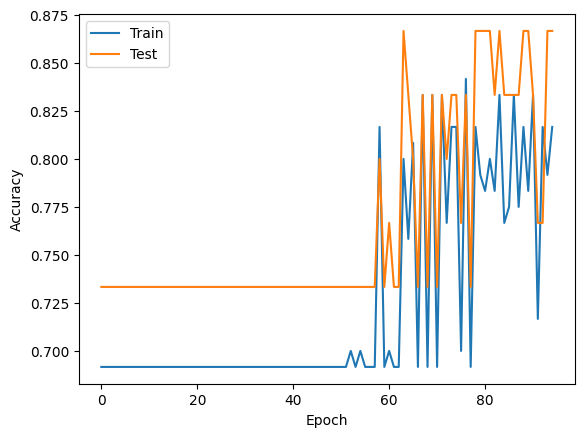

In [ ]:
# THIS PART IS USED FOR FINDING THE BEST HYPERPARAMETERS

train_dataset = Subset(dataset, train_idx)

# Subsets for train and validation
train_subdataset = Subset(train_dataset, train_idx_val)
val_subdataset = Subset(train_dataset, val_idx)

# DataLoaders for these subsets
train_loader = DataLoader(train_subdataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subdataset, batch_size=32, shuffle=False)

# Model with GINConv layers
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.convs = nn.ModuleList()
        
        mlp1 = nn.Sequential(
            nn.Linear(7, 6),
            nn.ReLU(),
            nn.Linear(6, 6)
        )
        self.convs.append(GINConv(mlp1))
        
        for _ in range(15):  
            mlp = nn.Sequential(
                nn.Linear(6, 6),
                nn.ReLU(),
                nn.Linear(6, 6)
            )
            self.convs.append(GINConv(mlp))

        self.fc6 = nn.Linear(6, 2) # Embedding layer
        self.fin = nn.Linear(2, 2)  
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = self.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)  
        embedding = self.fc6(x) # Embedding
        out = self.fin(embedding)  
        return out, embedding


model = Model2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_acc, val_acc = [], []
embeddings = []
predictions = []
true_labels = []
for epoch in range(95):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs, embedding = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        # Train
        correct = 0
        total = 0
        for batch in train_loader:
            out, embedding = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        train_acc.append(correct / total)

        # Val
        correct = 0
        total = 0
        for batch in val_loader:
            out, embedding = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)

            embeddings.append(embedding)
            true_labels.append(batch.y)
            predictions.append(pred)
            
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        val_acc.append(correct / total)

# Plot results
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

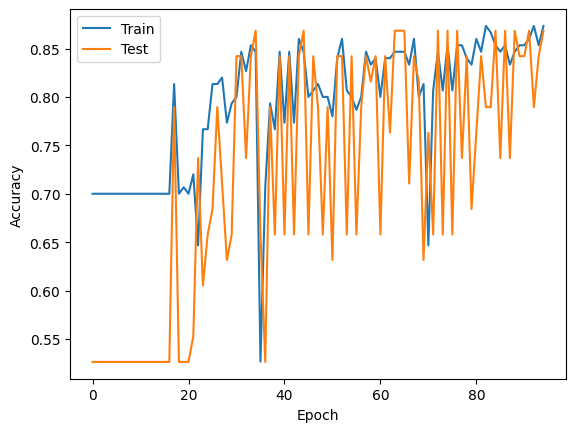

In [ ]:


train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model with GINConv layers
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.convs = nn.ModuleList()
        
        mlp1 = nn.Sequential(
            nn.Linear(7, 6),
            nn.ReLU(),
            nn.Linear(6, 6)
        )
        self.convs.append(GINConv(mlp1))
        
        for _ in range(15): 
            mlp = nn.Sequential(
                nn.Linear(6, 6),
                nn.ReLU(),
                nn.Linear(6, 6)
            )
            self.convs.append(GINConv(mlp))

        self.fc6 = nn.Linear(6, 2) # Embedding layer
        self.fin = nn.Linear(2, 2) 
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = self.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)  
        embedding = self.fc6(x) # Embedding
        out = self.fin(embedding)  
        return out, embedding

model = Model2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_acc, val_acc = [], []
embeddings = []
predictions = []
true_labels = []
for epoch in range(95):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs, embedding = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        # Train
        correct = 0
        total = 0
        for batch in train_loader:
            out, embedding = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        train_acc.append(correct / total)

        # Val
        correct = 0
        total = 0
        for batch in test_loader:
            out, embedding = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)

            embeddings.append(embedding)
            true_labels.append(batch.y)
            predictions.append(pred)
            
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        val_acc.append(correct / total)

# Plot results
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

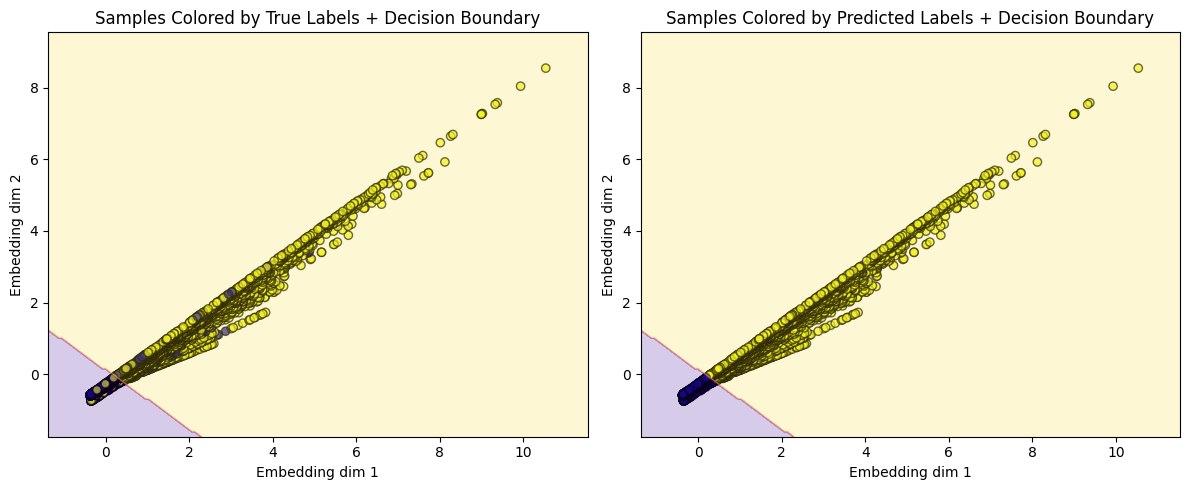

In [ ]:
# Convert lists to tensors
embeddings_tensor = torch.cat(embeddings, dim=0)
true_labels_tensor = torch.cat(true_labels, dim=0)
predictions_tensor = torch.cat(predictions, dim=0)

# Convert tensors to NumPy for plotting
emb_np = embeddings_tensor.numpy()
true_np = true_labels_tensor.numpy()
pred_np = predictions_tensor.numpy()

# Define grid boundaries based on the embedded space
x_min, x_max = emb_np[:, 0].min() - 1, emb_np[:, 0].max() + 1
y_min, y_max = emb_np[:, 1].min() - 1, emb_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid_points.astype(np.float32))

# Pass grid points through the classifier
model.eval()
with torch.no_grad():
    grid_outputs = model.fin(grid_tensor)  # Using final classification layer
    grid_preds = torch.argmax(grid_outputs, dim=1).numpy()

grid_preds = grid_preds.reshape(xx.shape)

# Plot true labels with decision boundary shading
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(emb_np[:, 0], emb_np[:, 1], c=true_np, cmap='plasma', edgecolor='k', alpha=0.7)
plt.contourf(xx, yy, grid_preds, alpha=0.2, cmap='plasma')  # Shading
plt.title("Samples Colored by True Labels + Decision Boundary")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")

# Plot predicted labels with decision boundary shading
plt.subplot(1, 2, 2)
plt.scatter(emb_np[:, 0], emb_np[:, 1], c=pred_np, cmap='plasma', edgecolor='k', alpha=0.7)
plt.contourf(xx, yy, grid_preds, alpha=0.2, cmap='plasma')  # Shading
plt.title("Samples Colored by Predicted Labels + Decision Boundary")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")

plt.tight_layout()
plt.show()